# End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF

In [1]:
from __future__ import print_function
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time,os,sys,codecs,re,urllib,math
import _pickle as cPickle

plt.rcParams['figure.dpi'] = 80
plt.style.use('seaborn-pastel')

In [2]:
#parameters for the Model
parameters = OrderedDict()

#Dataset parameter
parameters['train'] = "./data/eng.train" #Path to train file
parameters['dev'] = "./data/eng.testa" #Path to test file
parameters['test'] = "./data/eng.testb" #Path to dev file
parameters['tag_scheme'] = "BIOES" #BIO or BIOES
parameters['lower'] =  True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 

#Model parameter
parameters['char_dim'] = 30 #Char embedding dimension
parameters['word_dim'] = 100 #Token embedding dimension
parameters['word_lstm_dim'] = 200 #Token LSTM hidden layer size
parameters['word_bidirect'] = True #Use a bidirectional LSTM for words

parameters['word_cnn_dim'] =  17 #use in the last hidden node that map from conv to tagset size
parameters['crf'] =1 #Use CRF (0 to disable)
parameters['dropout'] = 0.5 #Droupout on the input (0 = no dropout)
parameters['name'] = "self-trained-bilstm-crf" # Model name
parameters['char_mode']="CNN"
parameters['word_mode']="CNN"
parameters['weights'] = "" #path to Pretrained for from a previous run

models_path = "./models/" #path to saved models

#Embedding
parameters['embedding_path'] = "./data/glove.6B.100d.txt" #Location of pretrained embeddings
parameters['all_emb'] = 1 #Load all embeddings

#Training Config
parameters['epoch'] =  50 #Number of epochs to run"
parameters['gradient_clip']=5.0

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

parameters['reload'] = "./models/pre-trained-model" 


#########################CHANGE THIS PARAM FOR FULL TRAINING####################################
parameters['debug_whole_script'] = True
if parameters['debug_whole_script']:
        parameters['epoch'] =  10
        parameters['name'] = 'DEBUG_MODEL'

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'
CNN_ARCHI_LIST = [
                  'CNN_1_NO_MAXPOOL',
                  'CNN_3_NO_MAXPOOL',
                  'CNN_1_MAXPOOL',
                  'CNN_3_MAXPOOL'                
                 ]  ##search for ADD_CNN_ARCHI if you want to add more architectures

In [3]:
#paths to files 
#To stored mapping file
mapping_file = './data/mapping.pkl'

if not os.path.exists(models_path):
    os.makedirs(models_path)

In [4]:
from utils import *

In [5]:
train_sentences = load_sentences(parameters['train'], parameters['zeros'])
test_sentences = load_sentences(parameters['test'], parameters['zeros'])
dev_sentences = load_sentences(parameters['dev'], parameters['zeros'])


if parameters['debug_whole_script']:
    limiter = 1000
    train_sentences = train_sentences[:limiter]
    test_sentences = test_sentences[:limiter]
    dev_sentences = dev_sentences[:limiter]
    
update_tag_scheme(train_sentences, parameters['tag_scheme'])
update_tag_scheme(dev_sentences, parameters['tag_scheme'])
update_tag_scheme(test_sentences, parameters['tag_scheme'])

dico_words,word_to_id,id_to_word = word_mapping(train_sentences, parameters['lower'])
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

train_data = prepare_dataset(train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower'])
dev_data = prepare_dataset(dev_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower'])
test_data = prepare_dataset(test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower'])

print("{} / {} / {} sentences in train / dev / test.".format(len(train_data), len(dev_data), len(test_data)))

Found 2952 unique words (12057 in total)
Found 68 unique characters
Found 19 unique named entity tags
1000 / 1000 / 1000 sentences in train / dev / test.


In [6]:
all_word_embeds = {}
for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

with open(mapping_file, 'wb') as f:
    mappings = {
        'word_to_id': word_to_id,
        'tag_to_id': tag_to_id,
        'char_to_id': char_to_id,
        'parameters': parameters,
        'word_embeds': word_embeds
    }
    cPickle.dump(mappings, f)

print('word_to_id: ', len(word_to_id))

Loaded 400000 pretrained embeddings.
word_to_id:  2952


In [7]:
##model building -- this is the only part we need to change 
def get_features(self, sentence, chars2, chars2_length, d,cnn_archi='CNN_3_NO_MAXPOOL'):
    
    if self.char_mode == 'LSTM':
        
            chars_embeds = self.char_embeds(chars2).transpose(0, 1)
            
            packed = torch.nn.utils.rnn.pack_padded_sequence(chars_embeds, chars2_length)
            
            lstm_out, _ = self.char_lstm(packed)
            
            outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
            
            outputs = outputs.transpose(0, 1)
            
            chars_embeds_temp = Variable(torch.FloatTensor(torch.zeros((outputs.size(0), outputs.size(2)))))
            
            if self.use_gpu:
                chars_embeds_temp = chars_embeds_temp.cuda()
            
            for i, index in enumerate(output_lengths):
                chars_embeds_temp[i] = torch.cat((outputs[i, index-1, :self.char_lstm_dim], outputs[i, 0, self.char_lstm_dim:]))
            
            chars_embeds = chars_embeds_temp.clone()
            
            for i in range(chars_embeds.size(0)):
                chars_embeds[d[i]] = chars_embeds_temp[i]
    
    
    if self.char_mode == 'CNN':
        chars_embeds = self.char_embeds(chars2).unsqueeze(1)
        chars_cnn_out3 = self.char_cnn3(chars_embeds)
        chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)
    ## Loading word embeddings
    embeds = self.word_embeds(sentence)

    ## We concatenate the word embeddings and the character level representation
    ## to create unified representation for each word
    embeds = torch.cat((embeds, chars_embeds), 1)
    
    embeds = embeds.transpose(0,1).contiguous()

    embeds = embeds.unsqueeze(0)

    ## Dropout on the unified embeddings
    embeds = self.dropout(embeds)
    
    ## Word level encoder
    ## lstm
    if self.word_mode == 'LSTM':
        ## Takes words as input and generates a output at each step
        lstm_out, _ = self.lstm(embeds)

        ## Reshaping the outputs from the lstm layer
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)

        ## Dropout on the lstm output
        lstm_out = self.dropout(lstm_out)

        ## Linear layer converts the ouput vectors to tag space
        lstm_feats = self.hidden2tag(lstm_out)
        
        return lstm_feats
    ## CNN
    if self.word_mode == 'CNN':
        ## ADD_CNN_ARCHI HERE
        assert cnn_archi in CNN_ARCHI_LIST, f"{cnn_archi} not supported, currently supporting {', '.join(CNN_ARCHI_LIST)}"
        if cnn_archi == 'CNN_1_MAXPOOL':
            conv_out = self.conv_1(embeds)
            relu = nn.functional.relu(conv_out)
            pool_1 = self.maxpool_1(relu)
            pool_squeeze = pool_1.squeeze(0).transpose(0,1).contiguous() 
            cnn_feats = self.fc_1(pool_squeeze)
            return cnn_feats
        
        elif cnn_archi == 'CNN_3_MAXPOOL':
            conv_out1 = self.conv_1(embeds)   
            relu_1 = nn.functional.relu(conv_out1) 
            maxpool_1 = self.maxpool_1(relu_1)
            conv_out2 = self.conv_2(maxpool_1)
            relu_2 = nn.functional.relu(conv_out2)
            maxpool_2 = self.maxpool_2(relu_2)
            conv_out3 = self.conv_3(maxpool_2)
            relu_3 = nn.functional.relu(conv_out3)
            #maxpool_3 = self.maxpool_3(relu_3)
            pool_squeeze = relu_3.squeeze(0).transpose(0,1).contiguous() 
            cnn_feats = self.fc_1(pool_squeeze)
            return cnn_feats
        
        elif cnn_archi == 'CNN_1_NO_MAXPOOL':
            conv_out = self.conv_1(embeds)
            relu = nn.functional.relu(conv_out)
            relu_squeeze = relu.squeeze(0).transpose(0,1).contiguous() 
            cnn_feats = self.fc_1(relu_squeeze)
            return cnn_feats
        
        elif cnn_archi == 'CNN_3_NO_MAXPOOL':         
            conv_out1 = self.conv_1(embeds)   
            relu_1 = nn.functional.relu(conv_out1)       
            conv_out2 = self.conv_2(relu_1)
            relu_2 = nn.functional.relu(conv_out2)
            conv_out3 = self.conv_3(relu_2)
            relu_3 = nn.functional.relu(conv_out3)
            squeeze_relu = relu_3.squeeze(0).transpose(0,1).contiguous()
            cnn_feats = self.fc_1(squeeze_relu)
            return cnn_feats
        

        

In [8]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,hidden_cnn_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25,char_embedding_dim=25, use_gpu=False
                 , use_crf=True, char_mode='CNN', word_mode='CNN',cnn_archi='CNN_1_MAXPOOL'):
        '''
        Input parameters:
                
                vocab_size= Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                use_gpu = defines availability of GPU, 
                    when True: CUDA function calls are made
                    else: Normal CPU function calls are made
                use_crf = parameter which decides if you want to use the CRF layer for output decoding
        '''
        
        super(BiLSTM_CRF, self).__init__()
        
        #parameter initialization for the model
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_out_dimension
        self.char_mode = char_mode
        self.word_mode = word_mode
        self.hidden_cnn_dim = hidden_cnn_dim

        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim
            
            #Initializing the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)
            
            #Performing LSTM encoding on the character embeddings
            if self.char_mode == 'LSTM':
                self.char_lstm = nn.LSTM(char_embedding_dim, char_lstm_dim, num_layers=1, bidirectional=True)
                init_lstm(self.char_lstm)
                
            #Performing CNN encoding on the character embeddings
            if self.char_mode == 'CNN':
                #print("char_embedding_dim:", char_embedding_dim)
                self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))

        #Creating Embedding layer with dimension of ( number of words * dimension of each word)
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            #Initializes the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False
    
        #Initializing the dropout layer, with dropout specificed in parameters
        self.dropout = nn.Dropout(parameters['dropout'])
        
        # word encoding layer
        #Lstm Layer:
        if self.word_mode == 'LSTM':
            #input dimension: word embedding dimension + character level representation
            #bidirectional=True, specifies that we are using the bidirectional LSTM
            if self.char_mode == 'LSTM':
                self.lstm = nn.LSTM(embedding_dim+char_lstm_dim*2, hidden_dim, bidirectional=True)
            if self.char_mode == 'CNN':
                #print("char_mode = CNN, embedding_dim: ", embedding_dim)
                self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)

            #Initializing the lstm layer using predefined function for initialization
            init_lstm(self.lstm)

            # Linear layer which maps the output of the bidirectional LSTM into tag space.
            self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

            #Initializing the linear layer using predefined function for initialization
            init_linear(self.hidden2tag) 

            if self.use_crf:
                # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
                # Matrix has a dimension of (total number of tags * total number of tags)
                self.transitions = nn.Parameter(
                    torch.zeros(self.tagset_size, self.tagset_size))

                # These two statements enforce the constraint that we never transfer
                # to the start tag and we never transfer from the stop tag
                self.transitions.data[tag_to_ix[START_TAG], :] = -10000
                self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        
        if self.char_mode == 'CNN':
            #input dimension: word embedding dimension + character level representation
            if self.word_mode == 'CNN':
                ## ADD_CNN_ARCHI HERE
                assert cnn_archi in CNN_ARCHI_LIST, f"{archi} not supported, currently supporting {', '.join(CNN_ARCHI_LIST)}"
                if cnn_archi == 'CNN_1_MAXPOOL':
                    self.conv_1 = nn.Conv1d(in_channels=embedding_dim+self.out_channels, out_channels=self.hidden_cnn_dim, kernel_size=3, padding=1, stride=1)
                    self.maxpool_1 = nn.MaxPool1d(kernel_size = 3, stride = 1, padding = 1)                
                    self.flatten = nn.Flatten()

                    # Linear layer which maps the output of the CNN into tag space.
                    self.fc_1 = nn.Linear(self.hidden_cnn_dim, self.tagset_size)
                    
                elif cnn_archi == 'CNN_3_MAXPOOL':
                    self.conv_1 = nn.Conv1d(in_channels=embedding_dim+self.out_channels, out_channels=32, kernel_size=3, padding=1, stride=1)
                    self.conv_2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=1)     
                    self.conv_3 = nn.Conv1d(in_channels=16, out_channels=self.hidden_cnn_dim, kernel_size=3, padding=1, stride=1)  
                    self.maxpool_1 = nn.MaxPool1d(kernel_size = 3, stride = 1, padding = 1)  
                    self.maxpool_2 = nn.MaxPool1d(kernel_size = 3, stride = 1, padding = 1) 
                    self.maxpool_3 = nn.MaxPool1d(kernel_size = 3, stride = 1, padding = 1) 
                    self.flatten = nn.Flatten()

                    # Linear layer which maps the output of the CNN into tag space.
                    self.fc_1 = nn.Linear(self.hidden_cnn_dim, self.tagset_size)
                    
                elif cnn_archi == 'CNN_1_NO_MAXPOOL':
                    self.conv_1 = nn.Conv1d(in_channels=embedding_dim+self.out_channels, out_channels=self.hidden_cnn_dim, kernel_size=3, padding=1, stride=1)                   
                    self.flatten = nn.Flatten()
                    # Linear layer which maps the output of the CNN into tag space.
                    self.fc_1 = nn.Linear(self.hidden_cnn_dim, self.tagset_size)
                
                elif cnn_archi == 'CNN_3_NO_MAXPOOL':
                    self.conv_1 = nn.Conv1d(in_channels=embedding_dim+self.out_channels, out_channels=32, kernel_size=3, padding=1, stride=1)
                    self.conv_2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=1)     
                    self.conv_3 = nn.Conv1d(in_channels=16, out_channels=self.hidden_cnn_dim, kernel_size=3, padding=1, stride=1)                   
                    self.flatten = nn.Flatten()

                    # Linear layer which maps the output of the CNN into tag space.
                    self.fc_1 = nn.Linear(self.hidden_cnn_dim, self.tagset_size)
                
                
        if self.use_crf:
            # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
            # Matrix has a dimension of (total number of tags * total number of tags)
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))

            # These two statements enforce the constraint that we never transfer
            # to the start tag and we never transfer from the stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
                

    #assigning the functions, which we have defined earlier
    _score_sentence = score_sentences
    _get_features = get_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

In [9]:
models = {} #we gonna run all experiments in one shot

for cnn_archi in CNN_ARCHI_LIST:  #this is for final run 
    
#for cnn_archi in ['CNN_3_MAXPOOL','CNN_3_NO_MAXPOOL']:   #this is for debugging certain model

    models[cnn_archi]=BiLSTM_CRF(vocab_size=len(word_to_id),
                       tag_to_ix=tag_to_id,
                       embedding_dim=parameters['word_dim'],
                       hidden_dim=parameters['word_lstm_dim'],
                       hidden_cnn_dim=parameters['word_cnn_dim'],
                       use_gpu=use_gpu,
                       char_to_ix=char_to_id,
                       pre_word_embeds=word_embeds,
                       use_crf=parameters['crf'],
                       char_mode=parameters['char_mode'],
                       cnn_archi=cnn_archi)
    
    print(f"Model {cnn_archi} initialized!!!")

    if use_gpu:
        models[cnn_archi].cuda()

Model CNN_1_NO_MAXPOOL initialized!!!
Model CNN_3_NO_MAXPOOL initialized!!!
Model CNN_1_MAXPOOL initialized!!!
Model CNN_3_MAXPOOL initialized!!!


In [10]:
def evaluating(model, datas, best_F,cnn_archi='CNN_3_NO_MAXPOOL',dataset="Train"):
    '''
    The function takes as input the model, data and calcuates F-1 Score
    It performs conditional updates 
     1) Flag to save the model 
     2) Best F-1 score
    ,if the F-1 score calculated improves on the previous F-1 score
    '''
    # Initializations
    prediction = [] # A list that stores predicted tags
    save = False # Flag that tells us if the model needs to be saved
    new_F = 0.0 # Variable to store the current F1-Score (may not be the best)
    correct_preds, total_correct, total_preds = 0., 0., 0. # Count variables
    
    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']
        
        if parameters['char_mode'] == 'LSTM':
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            d = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in d and not i in d.values():
                        d[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        
        if parameters['char_mode'] == 'CNN':
            d = {} 

            # Padding the each word to max word size of that sentence
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))

        dwords = Variable(torch.LongTensor(data['words']))
        
        # We are getting the predicted output from our model
        if use_gpu:
            val,out = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d,cnn_archi)
        else:
            val,out = model(dwords, chars2_mask, chars2_length, d,cnn_archi)
        predicted_id = out
    
        
        # We use the get chunks function defined above to get the true chunks
        # and the predicted chunks from true labels and predicted labels respectively
        lab_chunks      = set(get_chunks(ground_truth_id,tag_to_id))
        lab_pred_chunks = set(get_chunks(predicted_id,
                                         tag_to_id))

        # Updating the count variables
        correct_preds += len(lab_chunks & lab_pred_chunks)
        total_preds   += len(lab_pred_chunks)
        total_correct += len(lab_chunks)
    
    # Calculating the F1-Score
    p   = correct_preds / total_preds if correct_preds > 0 else 0
    r   = correct_preds / total_correct if correct_preds > 0 else 0
    new_F  = 2 * p * r / (p + r) if correct_preds > 0 else 0


    
    # If our current F1-Score is better than the previous best, we update the best
    # to current F1 and we set the flag to indicate that we need to checkpoint this model
    

    if dataset == "Test":
        print("{}: test_F: {} \n".format(dataset,new_F))
    else:
        print("{}: new_F: {} best_F: {} ".format(dataset,new_F,best_F))
        
    if new_F>best_F:
        best_F=new_F
        save=True #this will be disregarded for train anyway
    
    return best_F, new_F, save

MODEL TRAINING FOR  CNN_1_NO_MAXPOOL  STARTED!!

Epoch no:  1
200 :  0.9300890628367344
400 :  0.7671307193883428
600 :  0.5369457785194797
800 :  0.46772979837944745
1000 :  0.36408257095422747

Epoch no:  2
1200 :  0.40586142889268445
1400 :  0.3105951208238887
1600 :  0.3787499060383914
1800 :  0.29917293565418
2000 :  0.3055463747242476

Epoch no:  3
2200 :  0.29006002591224594
2400 :  0.27167269481947987
2600 :  0.2306991651417098
2800 :  0.22948040079998108
3000 :  0.224037141555367

Epoch no:  4
3200 :  0.24504298601888824
3400 :  0.20655800708775438
3600 :  0.21508629284217348
3800 :  0.18691341009497658
4000 :  0.21883177615780294


>>>>>>>EVALUATING>>>>
Train: new_F: 0.8290182004614203 best_F: -1.0 
Dev: new_F: 0.5844011142061282 best_F: -1.0 
Saving Model to  ./models/DEBUG_MODEL_CNN_1_NO_MAXPOOL

Epoch no:  5
4200 :  0.15756163240159501
4400 :  0.1573490834873609
4600 :  0.16126220395155985
4800 :  0.17981648319509339
5000 :  0.21393316171701277

Epoch no:  6
5200 :  0.1104

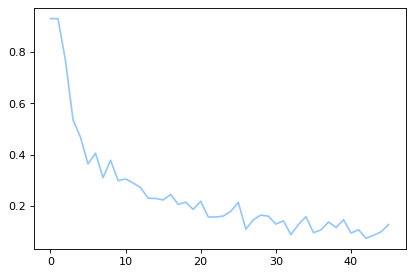

Test: test_F: 0.6440771349862259 

MODEL TRAINING FOR  CNN_3_NO_MAXPOOL  STARTED!!

Epoch no:  1
200 :  1.09417171872903
400 :  0.7332441107970287
600 :  0.587556538610288
800 :  0.4826097112655262
1000 :  0.548892855221261

Epoch no:  2
1200 :  0.4172816047172446
1400 :  0.4229157904568509
1600 :  0.40787948809354874
1800 :  0.44367380303402676
2000 :  0.39750558497222604

Epoch no:  3
2200 :  0.3196245451220373
2400 :  0.36037470872827376
2600 :  0.38905653832826464
2800 :  0.3637910379136644
3000 :  0.3314887990663996

Epoch no:  4
3200 :  0.3053144524298965
3400 :  0.33654971968516995
3600 :  0.28861632220483907
3800 :  0.2758551154443375
4000 :  0.364310547434186


>>>>>>>EVALUATING>>>>
Train: new_F: 0.7138810198300283 best_F: -1.0 
Dev: new_F: 0.5810310452862433 best_F: -1.0 
Saving Model to  ./models/DEBUG_MODEL_CNN_3_NO_MAXPOOL

Epoch no:  5
4200 :  0.3198056604621853
4400 :  0.21156906763931968
4600 :  0.21752180021165518
4800 :  0.33022350978633014
5000 :  0.22301696015885075

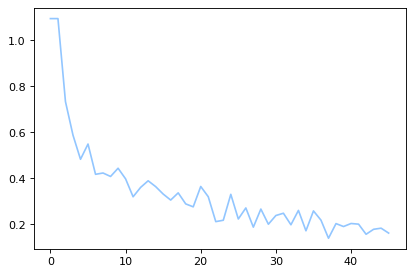

Test: test_F: 0.627831715210356 

MODEL TRAINING FOR  CNN_1_MAXPOOL  STARTED!!

Epoch no:  1
200 :  1.1448773234126142
400 :  0.8628435119359348
600 :  0.7512127399878178
800 :  0.7820128302546843
1000 :  0.651914804924086

Epoch no:  2
1200 :  0.6094907221066485
1400 :  0.5781279805512163
1600 :  0.5366943857335867
1800 :  0.4977558531467179
2000 :  0.5033973560293619

Epoch no:  3
2200 :  0.4918202281975853
2400 :  0.4553634419809057
2600 :  0.41893598511103636
2800 :  0.48065492251715397
3000 :  0.3949350634207006

Epoch no:  4
3200 :  0.35356051444897874
3400 :  0.45875259260890083
3600 :  0.40287805769928253
3800 :  0.3683777625927713
4000 :  0.4496928343247158


>>>>>>>EVALUATING>>>>
Train: new_F: 0.6350382999752903 best_F: -1.0 
Dev: new_F: 0.49102117394800326 best_F: -1.0 
Saving Model to  ./models/DEBUG_MODEL_CNN_1_MAXPOOL

Epoch no:  5
4200 :  0.36056261256959354
4400 :  0.2871973381602815
4600 :  0.3400631113097917
4800 :  0.3503371705868418
5000 :  0.3711801071527676

Epoch

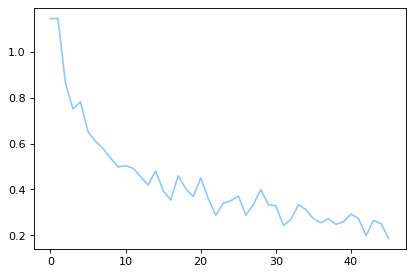

Test: test_F: 0.47975929978118165 

MODEL TRAINING FOR  CNN_3_MAXPOOL  STARTED!!

Epoch no:  1
200 :  1.1791512910108433
400 :  0.9382998172097231
600 :  0.9072505396957006
800 :  1.0090033027524132
1000 :  0.75060514738054

Epoch no:  2
1200 :  0.8693370727843573
1400 :  0.8251321918228831
1600 :  0.8980660699061641
1800 :  0.8376161923657304
2000 :  0.7193772294404804

Epoch no:  3
2200 :  0.6936071972940739
2400 :  0.7819793876948643
2600 :  0.7852154147775439
2800 :  0.7215768630245313
3000 :  0.6436049306201609

Epoch no:  4
3200 :  0.6299176839506668
3400 :  0.578166233212138
3600 :  0.6555078426659788
3800 :  0.691664544618889
4000 :  0.6860594862810112


>>>>>>>EVALUATING>>>>
Train: new_F: 0.32186836518046713 best_F: -1.0 
Dev: new_F: 0.18283392585068564 best_F: -1.0 
Saving Model to  ./models/DEBUG_MODEL_CNN_3_MAXPOOL

Epoch no:  5
4200 :  0.6287051627642831
4400 :  0.7170580957147266
4600 :  0.6039555814978377
4800 :  0.6889498481823638
5000 :  0.5716104755231007

Epoch no:  

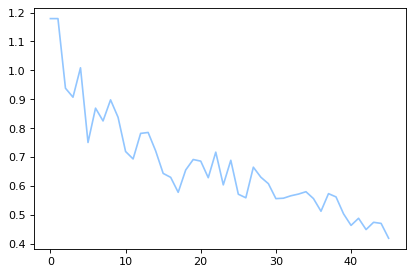

Test: test_F: 0.354829464029808 



In [11]:
parameters['reload']=False  

for cnn_archi,model in models.items():
    learning_rate = 0.015
    momentum = 0.9
    number_of_epochs = parameters['epoch'] 
    decay_rate = 0.05
    gradient_clip = parameters['gradient_clip']
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    #variables which will used in training process
    losses = [] #list to store all losses
    loss = 0.0 #Loss Initializatoin
    best_dev_F = -1.0 # Current best F-1 Score on Dev Set
    best_test_F = -1.0 # Current best F-1 Score on Test Set
    best_train_F = -1.0 # Current best F-1 Score on Train Set
    all_F = [[0, 0, 0]] # List storing all the F-1 Scores
    eval_every = len(train_data) # Calculate F-1 Score after this many iterations
    plot_every = int(eval_every/5) # Store loss after this many iterations
    count = 0 #Counts the number of iterations
    
    count = 0
    
    model_name = models_path + parameters['name'] + '_' + cnn_archi
    
    log_file = open(model_name+'.txt','w')

    
    if not parameters['reload']:
        print("MODEL TRAINING FOR ",cnn_archi," STARTED!!")
        tr = time.time()
        model.train(True)
        for epoch in range(1,number_of_epochs):   #
            print("\nEpoch no: ", epoch)
            log_file.write(f"Epoch #{epoch}:\n")
            for i, index in enumerate(np.random.permutation(len(train_data))):
                count += 1
                data = train_data[index]

                ##gradient updates for each data entry
                model.zero_grad()

                sentence_in = data['words']
                sentence_in = Variable(torch.LongTensor(sentence_in))
                tags = data['tags']
                chars2 = data['chars']

                if parameters['char_mode'] == 'LSTM':
                    chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
                    d = {}
                    for i, ci in enumerate(chars2):
                        for j, cj in enumerate(chars2_sorted):
                            if ci == cj and not j in d and not i in d.values():
                                d[j] = i
                                continue
                    chars2_length = [len(c) for c in chars2_sorted]
                    char_maxl = max(chars2_length)
                    chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
                    for i, c in enumerate(chars2_sorted):
                        chars2_mask[i, :chars2_length[i]] = c
                    chars2_mask = Variable(torch.LongTensor(chars2_mask))

                if parameters['char_mode'] == 'CNN':

                    d = {}

                    ## Padding the each word to max word size of that sentence
                    chars2_length = [len(c) for c in chars2]
                    char_maxl = max(chars2_length)
                    chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
                    for i, c in enumerate(chars2):
                        chars2_mask[i, :chars2_length[i]] = c
                    chars2_mask = Variable(torch.LongTensor(chars2_mask))


                targets = torch.LongTensor(tags)

                #we calculate the negative log-likelihood for the predicted tags using the predefined function
                if use_gpu:
                    neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length, d,cnn_archi)
                else:
                    neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d,cnn_archi)
                ams = neg_log_likelihood
                loss += neg_log_likelihood.item() / len(data['words'])     #change the data[0] to .item
                neg_log_likelihood.backward()

                #we use gradient clipping to avoid exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                optimizer.step()

                #Storing loss
                if count % plot_every == 0:
                    loss /= plot_every
                    print(count, ': ', loss)
                    log_file.write(F"{count}: {loss}\n")
                    if losses == []:
                        losses.append(loss)
                    losses.append(loss)
                    loss = 0.0

                #Evaluating on Train, Test, Dev Sets
                #eval once every epoch if epoch > 20
                #eval once every 4 epoch if epoch < 20
                if count % (eval_every) == 0 and count > (eval_every * 20) or count % (eval_every*4) == 0 and count < (eval_every * 20):
                    print("\n\n>>>>>>>EVALUATING>>>>")
                    log_file.write('\n')
                    model.train(False)

                    best_train_F, new_train_F, _ = evaluating(model, train_data, best_train_F,cnn_archi,"Train")
                    log_file.write("{}: new_F: {} best_F: {} \n".format('Train',new_train_F,best_train_F))

                    best_dev_F, new_dev_F, save = evaluating(model, dev_data, best_dev_F,cnn_archi,"Dev")
                    log_file.write("{}: new_F: {} best_F: {} \n".format('Dev',new_dev_F,best_dev_F))

                    if save:

                        print("Saving Model to ", model_name)
                        log_file.write(f"Saving Model to {model_name} at epoch {epoch}, iter {count}\n")
                        torch.save(model.state_dict(), model_name)


                    all_F.append([new_train_F, new_dev_F])
                    model.train(True)

                #Performing decay on the learning rate
                    if count % len(train_data) == 0:
                        adjust_learning_rate(optimizer, lr=learning_rate/(1+decay_rate*count/len(train_data)))

        print("training took: ",time.time() - tr,'s')
        log_file.write(f"training took: {time.time() - tr}s\n\n")
        
        plt.plot(losses)
        plt.savefig(model_name+'.png')
        plt.show()

        
        best_test_F, new_test_F, _ = evaluating(model, test_data, best_test_F,cnn_archi,"Test")
        log_file.write("{}: test_F: {} , best_F: {}\n".format('Test',new_test_F,best_test_F))
        log_file.close()
